# Cholesterol serem, Gender and Age to predict the pressence of heart disease patients from Cleveland
### Alina Hameed, San Kang, Siddarth Chilukuri, Sehan Malhotra

### Introduction:

In the medical field, doctors and other healthcare professionals have consistently sought ways to enhance patient health, detect early signs of illness, and facilitate timely intervention. They have explored various factors, such as diet, blood type, etc to alert individuals to potential health risks. **In this project, we will utilize easily accessible patient characteristics to predict the risk of developing heart disease, specifically focusing on serum cholesterol levels measured in mg/dL, age and sex.**

The "goal" field in the dataset indicates the presence of heart disease in patients is assigned integer values ranging from 0 (no presence) to 4. Previous experiments with the Cleveland database have primarily aimed at distinguishing between the presence of heart disease (values 1, 2, 3, 4) and its absence (value 0). 


### Preliminary exploratory data analysis

In [20]:
## loading in libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
install.packages("readxl")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [30]:
## reading csv, cleaning data

# Load the data file from online 
data <- read_csv(url("https://drive.google.com/uc?export=download&id=1aEyDR_0h4FG2FtFKyL_RbKkyNinISWPX")) 

# Essentially rename the condition column to diagnosis, then keep relevant columns
#     chol, age, and sex will be used to determine the diagnosis
data <- data |> mutate(diagnosis = condition) |> select(chol, age, sex, diagnosis) 

# This block of code converts the binary representation of the diagnosis to TRUE/FALSE for clarity 
# data <- data |> 
#   mutate(across(
#     diagnosis,
#     ~ recode(., "0" = FALSE, "1" = TRUE)
#   ))

# # Similarly, this converts the binary representation of sex to be "female" or "male" for clarity
# data <- data |>
#   mutate(across(
#     sex,
#     ~ recode(., "0" = "female", "1" = "male")
#   ))

write_csv(data, "data/prelim.csv")

set.seed(1232) 

Rows: 297 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
# Convert our diagnosis column to a factor as it will be treated as a categorical variable
data <- data |> mutate(diagnosis = as.factor(diagnosis))

data_split <- data |> initial_split(prop = 0.75, strata = diagnosis)  
data_training <- training(data_split)   
data_testing <- testing(data_split)

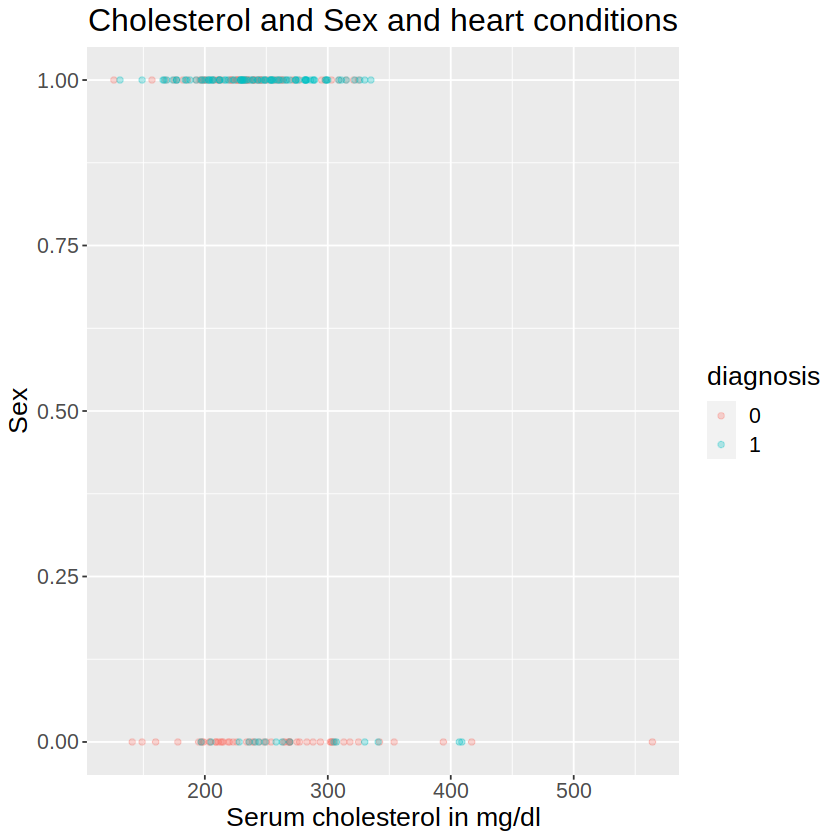

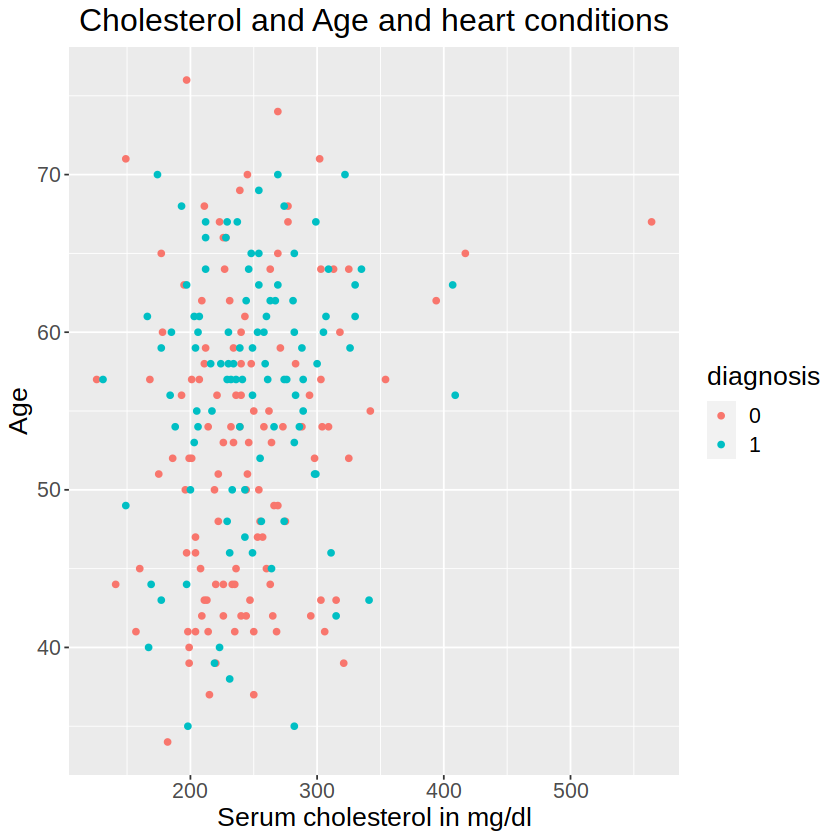

In [23]:
##plotting

#ploting cholesterol and sex
plot_chol_sex <- data_training |> ggplot(aes(x = chol, y = sex)) +
                    geom_point(alpha = 0.3, aes(colour = diagnosis)) +
                    labs(x = "Serum cholesterol in mg/dl", y = "Sex", title = "Cholesterol and Sex and heart conditions") +
                    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))
plot_chol_sex

#plotting cholesterol and age
plot_chol_age <- data_training |> ggplot(aes(x = chol, y = age)) +
                    geom_point(alpha = 1, aes(colour = diagnosis)) +
                    labs(x = "Serum cholesterol in mg/dl", y = "Age", title = "Cholesterol and Age and heart conditions") +
                    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))
plot_chol_age

### Methods

We first used select() to select the chol (Serum Cholesterol levels), age, sex, and condition (0 if the individual does not have the condition, 1 if they do) columns from our dataframe. Then, we used mutate() to mutate the condition column of the data to be “No” if the value is 0 and “Yes” if it is 1. Finally, we used mutate() to make the condition a factor and then used initial_split() to split our dataframe in a 3:1 ratio.

Because of its non-parametric nature, we plan on using the K Nearest Neighbors classification algorithm to identify if an individual has a heart condition based on their sex, age, and serum cholesterol levels. We chose these variables because they are relatively easy for patients to access and to also ensure that our classification is not influenced by other variables that have a lower correlation with the condition variable. We plan on creating a scatter plot using ggplot() to visualize, observe, and understand the final results and the relationship between the variables.



### Expected outcomes and significance

We expect that men will have a higher chance of having a heart condition based on the data. In terms of serum cholesterol levels, we expect that a higher value corresponds to a greater chance of having a heart condition. Finally, we expect that individuals below the age of 35 are less likely to have a heart condition. This will help hospitals and large medical institutions in planning their treatment procedure and resource allocation better and in accordance with these 3 categories. Furthermore, using the impact of age, sex and serum cholesterol levels can help arguably debunk myths and misconceptions about these heart diseases.These findings could lead to an investigation into this relationship based on demography. Currently, we are observing the relationship of age, sex, and serum cholesterol levels for individuals in Cleveland. Expanding our analysis to other parts of the world can showcase how different demographic locations foster different lifestyles, portraying how our analysis may change. 



neighbors
<int>
5


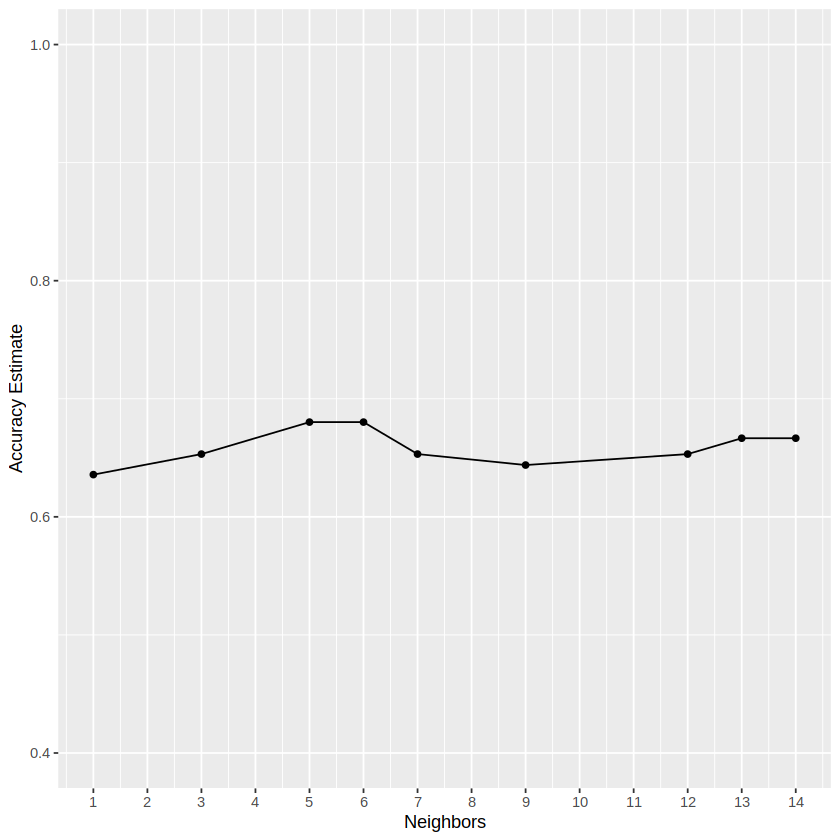

In [34]:
# running a cross validation to select the best k value

# performing the cross validation
heart_vfold <- vfold_cv(data_training, v = 10, strata = diagnosis)

# creating the recipe for our data, making sure to scale all the variables
heart_recipe <- recipe(diagnosis ~ chol + age + sex, data = data_training) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

# making a knn model specification to tune the number of neighbors
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                            set_engine("kknn") |>
                            set_mode("classification")

# creating a workflow to combine heart_recipe and heart_tune and then aggregating the mean and standard error. 
# we use tune_grid instead of fit here to fit the model for each value in a range of parmeter values. 
heart_results <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(heart_tune) |>
                  tune_grid(resamples = heart_vfold, grid = 10) |>
                  collect_metrics()

# filtering out just the accuracies from our metrics
accuracies <- heart_results |> 
                    filter(.metric == "accuracy")

#creaing a line plot using accuracies with neighbors on the x axis and mean on the y axis
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
                        geom_point() +
                        geom_line() +
                        labs(x = "Neighbors", y = "Accuracy Estimate") +
                        scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
                        scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

# selecting the best k value based on which has the highest accuracy to use for our model 
best_k <- accuracies |>
            filter(neighbors %% 2 != 0) |>
            arrange(mean) |>
            tail(n=1) |>
            select(neighbors)


accuracy_versus_k
best_k

In [36]:
# making a new (best) knn model

# creating a new knn model specification using the best k value we found earlier
heart_best_spec <- nearest_neighbor(weight_func = "rectangular", n = best_k) |>
                            set_engine("kknn") |>
                            set_mode("classification")

# creating a workflow to combine heart_recipe and heart_best_spec, then fitting it on our training data
heart_best_model <- workflow() |>
                        add_recipe(heart_recipe) |>
                        add_model(heart_best_spec) |>
                        fit(data = data_training)

# making predictions on the testing data using our new (best) model
heart_predictions <- knn_best_model |>
                        predict(data_testing) |>
                        bind_cols(data_testing)

# collecting accuracy and kap (a similar metric to accuract but normalized by the accuracy that would be expected by chance alone) 
# metrics from our predictions
heart_metrics <- heart_predictions |>
                        metrics(truth = diagnosis, estimate = .pred_class)

heart_predictions
heart_metrics

.pred_class,chol,age,sex,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,234,69,1,0
1,211,64,1,0
1,233,63,1,0
⋮,⋮,⋮,⋮,⋮
0,290,44,1,1
0,172,41,1,1
0,183,35,0,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6666667
kap,binary,0.3267504


In [37]:
# processing the prediction data to show which contingency table values for the predictions

# checking predicted diagnosis and actual diagnosis and determining which ones are true positives (TP), true negatives (TN), 
# false positives (FP), and false negatives (FN)
heart_pred_processed <- heart_pred |>
                            mutate(contingency = case_when((.pred_class == 1 & diagnosis == 1) ~ "TP",
                                                          (.pred_class == 0 & diagnosis == 0) ~ "TN",
                                                          (.pred_class == 1 & diagnosis == 0) ~ "FP",
                                                          (.pred_class == 0 & diagnosis == 1) ~ "FN"))

# collecting statistics to show how many TP, TN, FP, and FN we have
contingency_stats <- data.frame(true_positives = length(which(heart_pred_processed$contingency == "TP")),
                               true_negatives = length(which(heart_pred_processed$contingency == "TN")),
                               false_positives = length(which(heart_pred_processed$contingency == "FP")),
                               false_negatives = length(which(heart_pred_processed$contingency == "FN")))

heart_pred_processed
contingency_stats

.pred_class,chol,age,sex,diagnosis,contingency
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,234,69,1,0,FP
1,211,64,1,0,FP
1,233,63,1,0,FP
⋮,⋮,⋮,⋮,⋮,⋮
0,290,44,1,1,FN
0,172,41,1,1,FN
0,183,35,0,0,TN


true_positives,true_negatives,false_positives,false_negatives
<int>,<int>,<int>,<int>
21,29,11,14


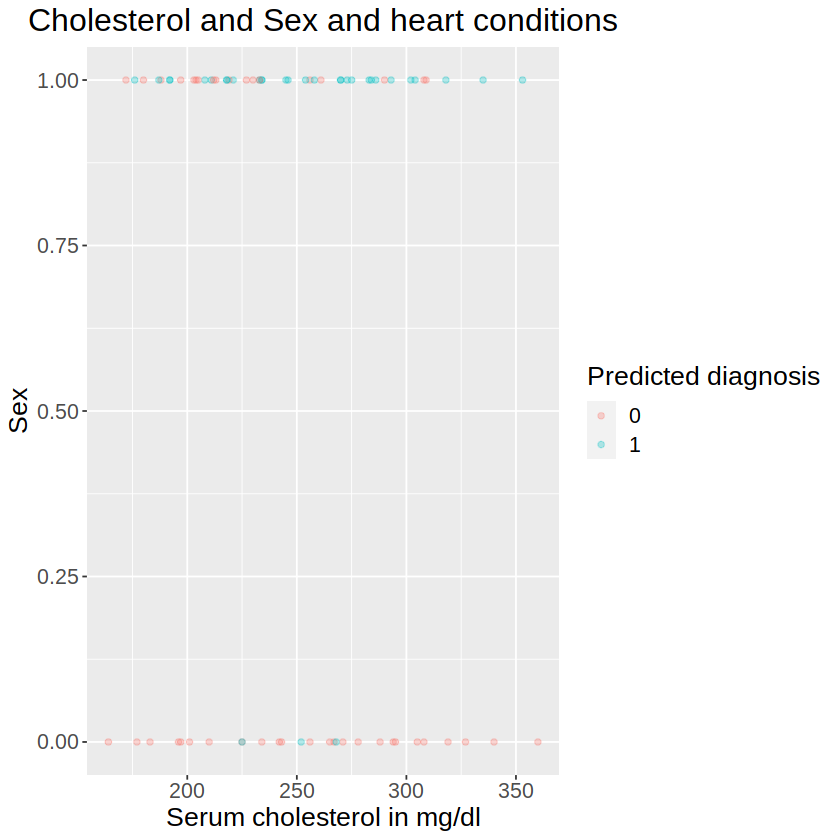

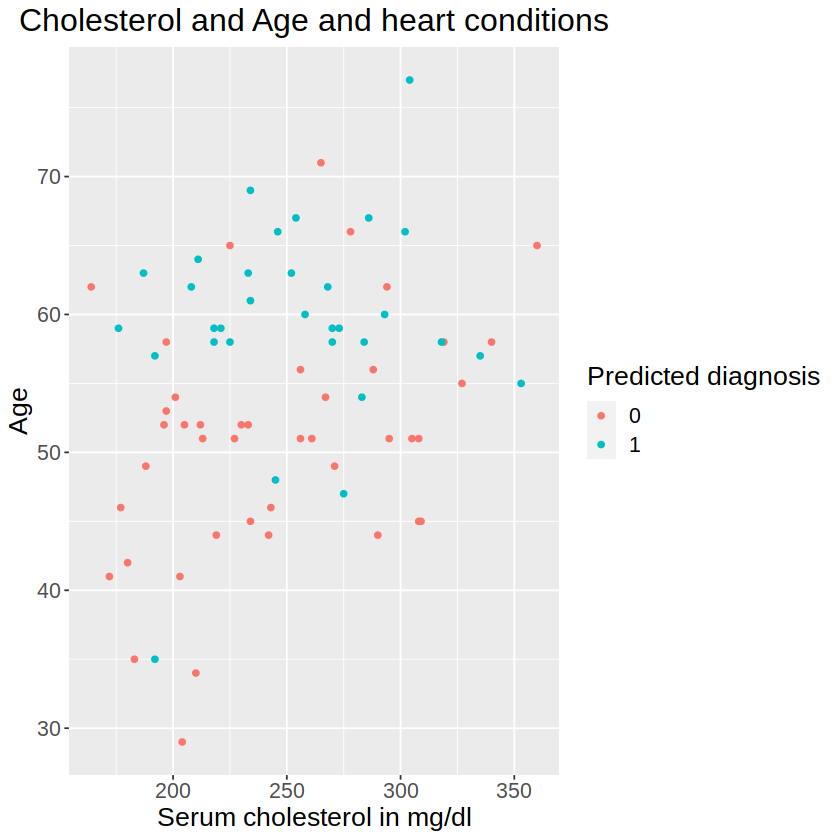

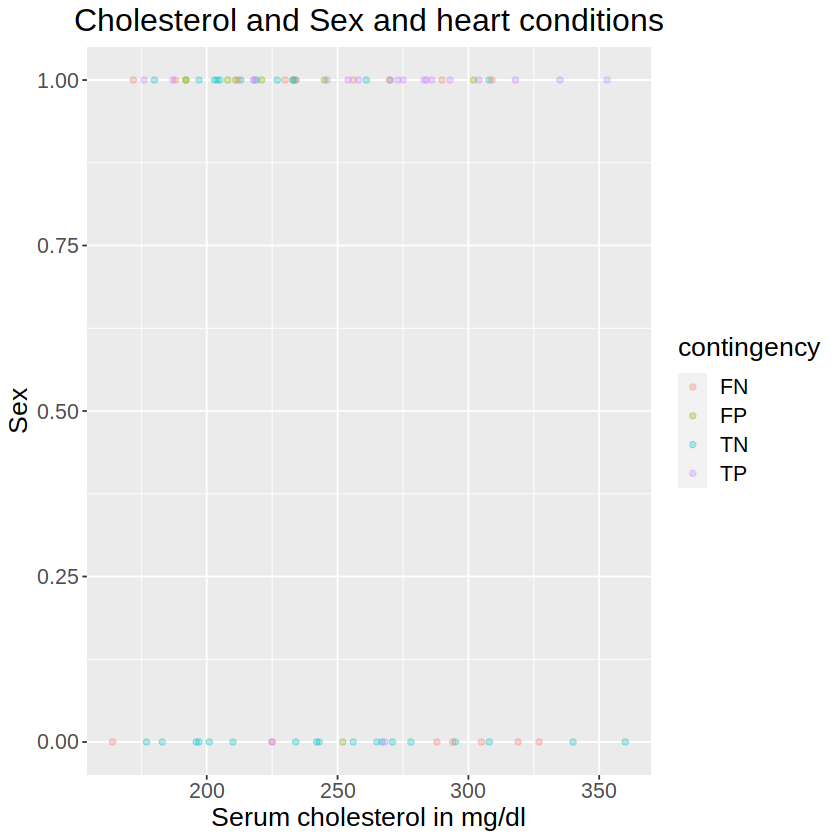

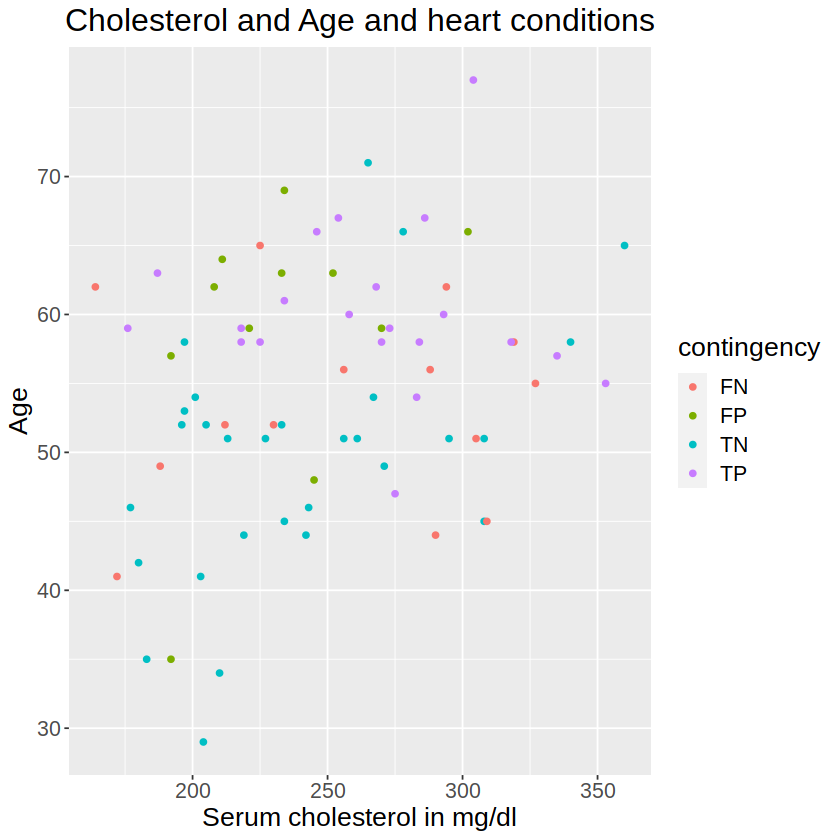

In [41]:
# visualizing the data analysis

# plotting cholestrol and sex and coloring points based on predicted diagnosis
plot_chol_sex_pred <- heart_pred_processed |> ggplot(aes(x = chol, y = sex)) +
                        geom_point(alpha = 0.3, aes(colour = .pred_class)) +
                        labs(x = "Serum cholesterol in mg/dl", y = "Sex", title = "Cholesterol and Sex and heart conditions", 
                             color = "Predicted diagnosis") +
                        theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))

#plotting cholesterol and age and coloring points based on predicted diagnosis
plot_chol_age_new <- heart_pred_processed |> ggplot(aes(x = chol, y = age)) +
                    geom_point(alpha = 1, aes(colour = .pred_class)) +
                    labs(x = "Serum cholesterol in mg/dl", y = "Age", title = "Cholesterol and Age and heart conditions",
                        color = "Predicted diagnosis") +
                    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))

#plotting cholesterol and sex and coloring points based on contingency table values
plot_chol_sex_new_c <- heart_pred_processed |> ggplot(aes(x = chol, y = sex)) +
                    geom_point(alpha = 0.3, aes(colour = contingency)) +
                    labs(x = "Serum cholesterol in mg/dl", y = "Sex", title = "Cholesterol and Sex and heart conditions") +
                    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))

#plotting cholesterol and age and coloring points based on contingency table values
plot_chol_age_new_c <- heart_pred_processed |> ggplot(aes(x = chol, y = age)) +
                    geom_point(alpha = 1, aes(colour = contingency)) +
                    labs(x = "Serum cholesterol in mg/dl", y = "Age", title = "Cholesterol and Age and heart conditions") +
                    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 16))

plot_chol_sex_pred
plot_chol_age_new
plot_chol_sex_new_c
plot_chol_age_new_c